In [1]:
from collections import defaultdict
from enum import IntEnum
import gymnasium as gym
import numpy as np

class Action(IntEnum):
    STICK = 0
    HIT = 1
    SURRENDER = 2
    DOUBLE = 3

class BlackjackAgent:
    def __init__(
        self,
        env: gym.Env,
        lr_bet: float,
        lr_play: float,
        initial_epsilon_bet: float,
        initial_epsilon_play: float,
        epsilon_decay_bet: float,
        epsilon_decay_play: float,
        final_epsilon_bet: float,
        final_epsilon_play: float,
        discount_factor: float = 0.99,
    ):
        """Initialize a SARSA agent.

        Args:
            env: The training environment
            lr_bet: How quickly to update Q-values in the betting phase (0-1)
            lr_play: How quickly to update Q-values in the playing phase (0-1)
            initial_epsilon: Starting exploration rate (usually 1.0)
            epsilon_decay: How much to reduce epsilon each episode
            final_epsilon: Minimum exploration rate (usually 0.1)
            discount_factor: How much to value future rewards (0-1)
        """
        base = getattr(env, "unwrapped", env)
        self.env = env
        self.base = base

        # Spaces
        self.n_bets = int(base.n_bets)
        self.n_tc = int(base.observation_space.spaces[3].n)

        # Q_bet[tc_bucket, n_bets]
        self.Q_bet = np.zeros((self.n_tc, self.n_bets), dtype=np.float32)
        # Visit counts for UCB per TC bucket and per action, plus total pulls per TC
        self.N_bet = np.zeros((self.n_tc, self.n_bets), dtype=np.int64)
        self.N_tc = np.zeros(self.n_tc, dtype=np.int64)

        # Q_play[player_sum(32), dealer(11), usable(2), tc_bucket, action(4)]
        # actions: 0=stand, 1=hit, 2=surrender, 3=double
        self.Q_play = np.zeros((32, 11, 2, self.n_tc, 4), dtype=np.float32)

        self.lr_bet = lr_bet
        self.lr_play = lr_play
        self.discount_factor = discount_factor  # How much we care about future rewards

        # Exploration parameters
        self.epsilon_bet = initial_epsilon_bet
        self.epsilon_play = initial_epsilon_play
        self.epsilon_decay_bet = epsilon_decay_bet
        self.epsilon_decay_play = epsilon_decay_play
        self.final_epsilon_bet = final_epsilon_bet
        self.final_epsilon_play = final_epsilon_play
        # UCB exploration constant (higher = more exploration bonus)
        self.ucb_c = 2.0

        # Track learning progress
        self.training_error_bet = []
        self.training_error_play = []

        self.rng = np.random.default_rng()

    # ---------- helpers ----------
    @staticmethod
    def _unpack(obs):
        # obs = (psum, dealer, usable, tc_idx, phase)
        return int(obs[0]), int(obs[1]), int(obs[2]), int(obs[3]), int(obs[4])

    def _idxs_play(self, obs):
        # obs = (psum, dealer, usable, tc_idx, phase)
        ps, dv, ua, tc, _ = self._unpack(obs)
        return ps, dv, ua, tc
    
    def _must_stick(self, obs):
        ps, _, _, _ = self._idxs_play(obs)
        return len(self.base.player) == 2 and ps == 21
    
    def get_valid_action_idx(self):
        return self.base.get_valid_actions_idxs()

    # ---------- ε-greedy policies ----------
    def select_bet(self, obs):
        # obs phase must be 0
        assert self.base.phase == 0
        tc_idx = int(obs[3])
        q = self.Q_bet[tc_idx]
        valid_bet_idx = self.get_valid_action_idx()
        assert valid_bet_idx == range(self.n_bets)
        if self.rng.random() < self.epsilon_bet:
            return int(self.rng.choice(list(valid_bet_idx)))
        # argmax with random tie-break
        m = q.max(); idxs = np.flatnonzero(q == m)
        return int(self.rng.choice(idxs))

    def select_play(self, obs):
        # obs phase must be 1
        assert self.base.phase == 1
        if self._must_stick(obs):
            return 0
        ps, dv, ua, tc = self._idxs_play(obs)
        q = self.Q_play[ps, dv, ua, tc]
        valid_play_idx = tuple(self.get_valid_action_idx())
        assert Action.HIT in valid_play_idx and Action.STICK in valid_play_idx # hit and stick should be minimally present
        if len(self.base.player) == 2:
            assert Action.SURRENDER in valid_play_idx
            assert Action.DOUBLE in valid_play_idx
        else:
            assert Action.SURRENDER not in valid_play_idx
            assert Action.DOUBLE not in valid_play_idx
        if self.rng.random() < self.epsilon_play:
            return int(self.rng.choice(valid_play_idx))   # sample among valid actions
        # Mask invalid actions by -inf to avoid selecting them
        q_masked = q.copy().astype(np.float64)
        all_actions = list(range(len(Action)))
        for a in all_actions:
            if a not in valid_play_idx:
                q_masked[a] = -np.inf
        m = np.max(q_masked); idxs = np.flatnonzero(q_masked == m)
        return int(self.rng.choice(idxs))
    
    # --------- UCB for betting ---------
    def select_bet_ucb(self, obs):
        """Select a bet action using UCB1 per true-count bucket.

        For each TC bucket, treat bet sizing as a multi-armed bandit. Use
        UCB1: argmax_a Q(tc,a) + c * sqrt(ln(N_tc) / N_tc,a), trying each action
        at least once before applying the bonus. Keeps separate counts per TC.
        """
        tc_idx = int(obs[3])

        counts = self.N_bet[tc_idx]
        total = int(self.N_tc[tc_idx])

        # Ensure each action is tried at least once in this TC bucket
        untried = np.flatnonzero(counts == 0)
        if untried.size > 0:
            a = int(self.rng.choice(untried))
        else:
            q = self.Q_bet[tc_idx].astype(np.float64)
            denom = counts.astype(np.float64)
            bonus = self.ucb_c * np.sqrt(np.log(max(total, 1)) / denom)
            ucb = q + bonus
            m = ucb.max(); idxs = np.flatnonzero(ucb == m)
            a = int(self.rng.choice(idxs))

        # Update visit counts
        self.N_bet[tc_idx, a] += 1
        self.N_tc[tc_idx] += 1
        return a
    
    # ---------- SARSA updates ----------
    def update_bet_sarsa(self, s0, a_bet, r0, s1, a1_play):
        # r0 is 0 in env; bootstrap through first play-state/action
        tc0 = int(s0[3])
        qsa = self.Q_bet[tc0, a_bet]
        target = r0 + self.discount_factor * self.Q_play[self._idxs_play(s1)][a1_play]
        td = target - qsa
        self.Q_bet[tc0, a_bet] += self.lr_bet * td
        self.training_error_bet.append(td)

    def update_bet_mc(self, s0, a_bet, G):
        # Monte-Carlo kick at episode end with full return
        tc0 = int(s0[3])
        qsa = self.Q_bet[tc0, a_bet]
        td = G - qsa
        self.Q_bet[tc0, a_bet] += self.lr_bet * td
        self.training_error_bet.append(td)

    def update_play_sarsa(self, s, a, r, done, s_next=None, a_next=None):
        ps, dv, ua, tc = self._idxs_play(s)
        qsa = self.Q_play[ps, dv, ua, tc, a]
        if done:
            target = r
        else:
            ps2, dv2, ua2, tc2 = self._idxs_play(s_next)
            target = r + self.discount_factor * self.Q_play[ps2, dv2, ua2, tc2, a_next]
        td = target - qsa
        self.Q_play[ps, dv, ua, tc, a] += self.lr_play * td
        self.training_error_play.append(td)

    # ---------- epsilon schedule ----------
    def decay_epsilon_bet(self):
        """Reduce exploration rate after each episode."""
        self.epsilon_bet = max(self.final_epsilon_bet, self.epsilon_bet - self.epsilon_decay_bet)
    
    def decay_epsilon_play(self):
        """Reduce exploration rate after each episode."""
        self.epsilon_play = max(self.final_epsilon_play, self.epsilon_play - self.epsilon_decay_play)

    # ---------- greedy (masked) for evaluation ----------
    def greedy_bet(self, obs):
        tc = int(obs[3]); q = self.Q_bet[tc]
        m = q.max(); idxs = np.flatnonzero(q == m)
        return int(self.rng.choice(idxs))

    def greedy_play(self, obs):
        ps, dv, ua, tc = self._idxs_play(obs)
        q = self.Q_play[ps, dv, ua, tc]
        valid_play_idx = tuple(self.get_valid_action_idx())
        q_masked = q.copy().astype(np.float64)
        for a in range(len(Action)):
            if a not in valid_play_idx:
                q_masked[a] = -np.inf
        m = np.max(q_masked); idxs = np.flatnonzero(q_masked == m)
        return int(self.rng.choice(idxs))

In [2]:
from env import BlackjackEnv

# Training hyperparameters
# learning_rate = 0.01        # How fast to learn (higher = faster but less stable) 
lr_bet = 0.01
lr_play = 0.01
n_preplay_episodes = 1_000_000
n_bet_episodes = 1_000_000
total_episodes = n_preplay_episodes + n_bet_episodes
start_epsilon_play = 1.0         # Start with 100% random actions
epsilon_decay_play = start_epsilon_play / max(n_preplay_episodes / 2, 1)  # Reduce exploration over time
final_epsilon_play = 0.1         # Always keep some exploration
start_epsilon_bet = 1.0         # Start with 100% random actions
epsilon_decay_bet = start_epsilon_bet / max(n_bet_episodes / 2, 1)  # Reduce exploration over time
final_epsilon_bet = 0.1         # Always keep some exploration

# Create environment and agent
env = BlackjackEnv(num_decks=4, tc_min=-10, tc_max=10, natural=True)
tc_min, tc_max = env.tc_min, env.tc_max
print(tc_min)
env = gym.wrappers.RecordEpisodeStatistics(env, buffer_length=total_episodes)

agent = BlackjackAgent(
    env=env,
    lr_bet=lr_bet,
    lr_play=lr_play,
    initial_epsilon_bet=start_epsilon_bet,
    initial_epsilon_play=start_epsilon_play,
    epsilon_decay_bet=epsilon_decay_bet,
    epsilon_decay_play=epsilon_decay_play,
    final_epsilon_bet=final_epsilon_bet,
    final_epsilon_play=final_epsilon_play,
    discount_factor=1.0
)

-10


In [3]:
import numpy as np
from tqdm.notebook import tqdm  # Progress bar

n_buckets = env.observation_space.spaces[3].n
hist_start_play = np.zeros(n_buckets, dtype=np.int64)
hist_start_bet = np.zeros(n_buckets, dtype=np.int64)

# ----- Stage 1: Learn the playing policy with a fixed base bet ----- #
base_bet_action = 0 # fixed multiplier 1.0x
for episode in tqdm(range(n_preplay_episodes), desc="Train Q_play"):
    # ----- Phase 0: fixed bet -----
    s0, _ = env.reset()
    tc_idx = s0[3]                     # integer in [0, n_buckets-1]
    hist_start_play[tc_idx] += 1
    s1, r0, term, trunc, _ = env.step(base_bet_action)
    assert s1[4] == 1 and not (term or trunc)
    a1 = agent.select_play(s1)

    # ----- Phase 1: play hand -----
    done = False
    s = s1; a = a1
    while not done:
        s_next, reward, terminated, truncated, _ = env.step(a)
        done = terminated or truncated
        if done:
            agent.update_play_sarsa(s, a, reward, True)
            break
        a_next = agent.select_play(s_next)
        agent.update_play_sarsa(s, a, reward, False, s_next, a_next)
        s, a = s_next, a_next

    agent.decay_epsilon_play()

# ----- Stage 2: Learn the betting policy using the trained Q_play ----- #
for episode in tqdm(range(n_bet_episodes), desc="Train Q_bet"):
    # ----- Phase 0: choose bet ----- #
    s0, _ = env.reset()
    tc_idx = s0[3]
    hist_start_bet[tc_idx] += 1
    a_bet = agent.select_bet_ucb(s0)
    s1, r0, term, trunc, _ = env.step(a_bet)
    assert s1[4] == 1 and not (term or trunc)
    a1 = agent.greedy_play(s1)

    # SARSA update for bet (better results when disabled)
    # agent.update_bet_sarsa(s0, a_bet, r0, s1, a1)

    # ----- Phase 1: play hand greedily ----- #
    G = r0
    done = False
    s = s1; a = a1
    while not done:
        s_next, reward, terminated, truncated, _ = env.step(a)
        G += reward
        done = terminated or truncated
        if done:
            break
        # a_next = agent.select_play(s_next)
        a_next = agent.greedy_play(s_next)
        s, a = s_next, a_next

    agent.update_bet_mc(s0, a_bet, G)

    agent.decay_epsilon_bet()

# Pretty print
hist_start = hist_start_play + hist_start_bet
names = getattr(env.unwrapped, "tc_bucket_names")
labels = np.array(names)
for b, c in zip(labels, hist_start_play):
    print(f"TC {b}: {c}")
print("coverage %:", np.round(100 * hist_start_play / hist_start_play.sum(), 2))
print("coverage %:", np.round(100 * hist_start_bet / hist_start_bet.sum(), 2))

Train Q_play:   0%|          | 0/1000000 [00:00<?, ?it/s]

Train Q_bet:   0%|          | 0/1000000 [00:00<?, ?it/s]

TC -10: 4166
TC -9: 2759
TC -8: 4509
TC -7: 7043
TC -6: 11203
TC -5: 17628
TC -4: 28535
TC -3: 44506
TC -2: 72679
TC -1: 116867
TC +0: 396634
TC +1: 109831
TC +2: 68532
TC +3: 42142
TC +4: 27700
TC +5: 17139
TC +6: 10620
TC +7: 6513
TC +8: 4419
TC +9: 2591
TC +10: 3984
coverage %: [ 0.42  0.28  0.45  0.7   1.12  1.76  2.85  4.45  7.27 11.69 39.66 10.98
  6.85  4.21  2.77  1.71  1.06  0.65  0.44  0.26  0.4 ]
coverage %: [ 0.42  0.27  0.47  0.71  1.14  1.79  2.87  4.43  7.23 11.7  39.32 11.08
  6.93  4.32  2.76  1.71  1.08  0.68  0.44  0.26  0.38]


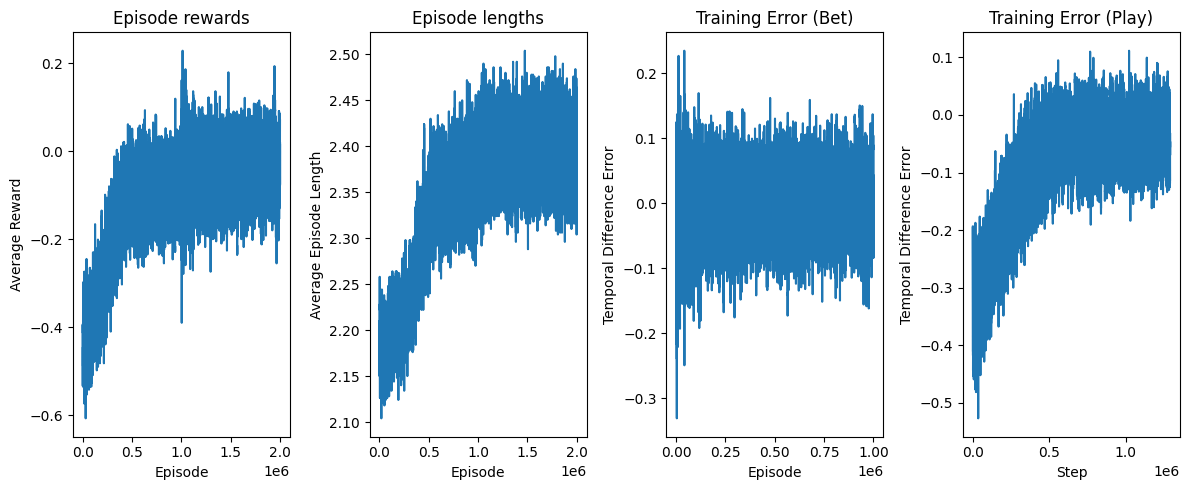

In [4]:
from matplotlib import pyplot as plt

def get_moving_avgs(arr, window, convolution_mode):
    """Compute moving average to smooth noisy data."""
    return np.convolve(
        np.array(arr).flatten(),
        np.ones(window),
        mode=convolution_mode
    ) / window

# Smooth over a 500-episode window
rolling_length = 500
fig, axs = plt.subplots(ncols=4, figsize=(12, 5))

# Episode rewards (win/loss performance)
axs[0].set_title("Episode rewards")
reward_moving_average = get_moving_avgs(
    env.return_queue,
    rolling_length,
    "valid"
)
axs[0].plot(range(len(reward_moving_average)), reward_moving_average)
axs[0].set_ylabel("Average Reward")
axs[0].set_xlabel("Episode")

# Episode lengths (how many actions per hand)
axs[1].set_title("Episode lengths")
length_moving_average = get_moving_avgs(
    env.length_queue,
    rolling_length,
    "valid"
)
axs[1].plot(range(len(length_moving_average)), length_moving_average)
axs[1].set_ylabel("Average Episode Length")
axs[1].set_xlabel("Episode")

# Training error (how much we're still learning)
axs[2].set_title("Training Error (Bet)")
training_error_bet_moving_average = get_moving_avgs(
    agent.training_error_bet,
    rolling_length,
    "same"
)
axs[2].plot(range(len(training_error_bet_moving_average)), training_error_bet_moving_average)
axs[2].set_ylabel("Temporal Difference Error")
axs[2].set_xlabel("Episode")

axs[3].set_title("Training Error (Play)")
training_error_play_moving_average = get_moving_avgs(
    agent.training_error_play,
    rolling_length,
    "same"
)
axs[3].plot(range(len(training_error_play_moving_average)), training_error_play_moving_average)
axs[3].set_ylabel("Temporal Difference Error")
axs[3].set_xlabel("Step")

plt.tight_layout()
plt.savefig('SARSA_plot.png', dpi=300, bbox_inches='tight')
plt.show()

In [5]:
def evaluate_bankroll(agent, env, episodes=200_000, rng=None):
    rng = rng or np.random.default_rng()
    returns = np.empty(episodes, dtype=np.float64)
    total_bet = 0.0
    wins = losses = pushes = 0

    for ep in range(episodes):
        s0, _ = env.reset()                    # phase 0 (bet)
        a_bet = agent.greedy_bet(s0)
        bet = float(env.unwrapped.bet_multipliers[int(a_bet) % env.unwrapped.n_bets])
        total_bet += bet

        # play hand
        s, _ = env.step(a_bet)[:2]
        done = False; G = 0.0
        while not done:
            a = agent.greedy_play(s)
            s, r, term, trunc, _ = env.step(a)
            G += r; done = term or trunc

        returns[ep] = G
        if G > 0: wins += 1
        elif G < 0: losses += 1
        else: pushes += 1

    ev = returns.mean()                        # units/hand
    se = returns.std(ddof=1) / np.sqrt(episodes)
    ci = (ev - 1.96*se, ev + 1.96*se)
    roi = ev / (total_bet / episodes)          # profit per unit bet

    summary = {
        "hands": episodes,
        "bankroll_change": returns.sum(),
        "ev_per_hand": ev,
        "ev_95%_CI": ci,
        "avg_bet": total_bet / episodes,
        "roi_per_hand": roi,
        "win_rate": wins / episodes,
        "loss_rate": losses / episodes,
        "push_rate": pushes / episodes,
    }
    return summary

results = evaluate_bankroll(agent, env, episodes=500_000)
print(results)

{'hands': 500000, 'bankroll_change': np.float64(-22210.0), 'ev_per_hand': np.float64(-0.04442), 'ev_95%_CI': (np.float64(-0.04731450002858393), np.float64(-0.04152549997141607)), 'avg_bet': 1.0, 'roi_per_hand': np.float64(-0.04442), 'win_rate': 0.397976, 'loss_rate': 0.524352, 'push_rate': 0.077672}


TC -10: mean=-0.1768  n=4256
TC -9: mean=-0.2005  n=2726
TC -8: mean=-0.1784  n=4687
TC -7: mean=-0.1666  n=7211
TC -6: mean=-0.1409  n=11577
TC -5: mean=-0.1219  n=18148
TC -4: mean=-0.1132  n=28711
TC -3: mean=-0.0720  n=44265
TC -2: mean=-0.0635  n=71987
TC -1: mean=-0.0390  n=115876
TC +0: mean=-0.0234  n=393293
TC +1: mean=-0.0281  n=110485
TC +2: mean=-0.0430  n=69310
TC +3: mean=-0.0535  n=43248
TC +4: mean=-0.0501  n=27864
TC +5: mean=-0.0325  n=17455
TC +6: mean=-0.0674  n=10950
TC +7: mean=-0.0773  n=6869
TC +8: mean=-0.0490  n=4668
TC +9: mean=-0.0472  n=2680
TC +10: mean=-0.0351  n=3734


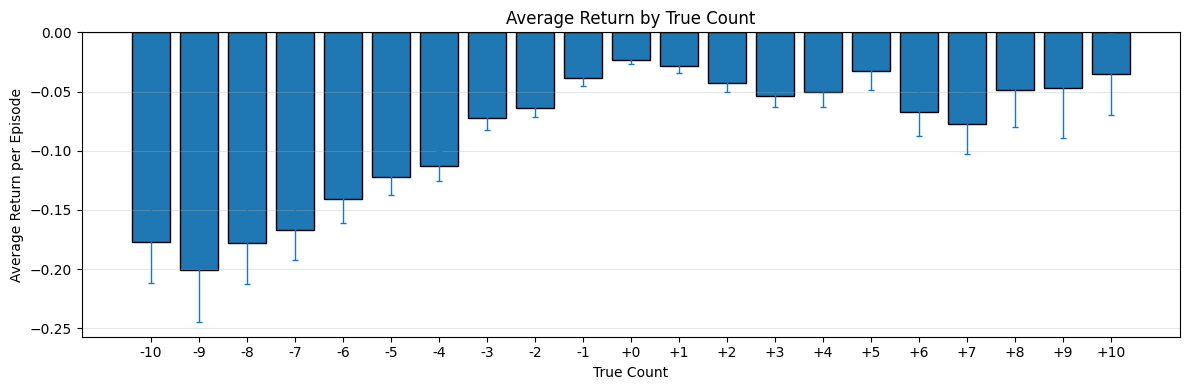

In [6]:
import numpy as np
from matplotlib import pyplot as plt

def eval_avg_return_by_tc(agent, env, episodes=200_000, rng=None):
    """
    Returns (labels, mean, (ci_lo, ci_hi), counts)
      labels: 1D array of TC values (tc_min..tc_max)
      mean:   avg return per hand for each TC bucket
      ci:     95% confidence intervals for each bucket
      counts: number of episodes that started in each TC bucket
    """
    rng = rng or np.random.default_rng()
    base = getattr(env, "unwrapped", env)
    n_buckets = env.observation_space.spaces[3].n
    names = getattr(env.unwrapped, "tc_bucket_names", ("≤-3","-2","-1","0","+1","+2","≥+3"))
    labels = np.array(names)  # for pretty ticks
    n_buckets = env.observation_space.spaces[3].n

    ret_sum   = np.zeros(n_buckets, dtype=np.float64)
    ret_sumsq = np.zeros(n_buckets, dtype=np.float64)
    counts    = np.zeros(n_buckets, dtype=np.int64)

    def pick_action(obs):
        # Split agent API (two Q tables)
        if hasattr(agent, "greedy_bet") and hasattr(agent, "greedy_play"):
            return int(agent.greedy_bet(obs) if obs[4] == 0 else agent.greedy_play(obs))
        # Fallback
        return int(agent.get_action(obs))

    for _ in range(episodes):
        obs, _ = env.reset()           # phase 0; obs[3] is the TC bucket index
        tc_idx = int(obs[3])

        # Play the full hand with the current policy (greedy or epsilon-greedy)
        done = False
        G = 0.0
        while not done:
            a = pick_action(obs)
            obs, r, term, trunc, _ = env.step(a)
            G += r
            done = term or trunc

        # Aggregate by start-of-hand TC
        ret_sum[tc_idx]   += G
        ret_sumsq[tc_idx] += G * G
        counts[tc_idx]    += 1

    # Means and 95% CIs per bucket
    denom = np.maximum(counts, 1)
    mean = ret_sum / denom
    var  = (ret_sumsq / denom) - mean**2
    se   = np.sqrt(np.maximum(var, 0.0) / denom)
    ci_lo = mean - 1.96 * se
    ci_hi = mean + 1.96 * se
    return labels, mean, (ci_lo, ci_hi), counts

def plot_avg_return_by_tc(labels, mean, ci, counts, min_visits=1000):
    ci_lo, ci_hi = ci
    mask = counts >= min_visits
    x = np.arange(len(labels))[mask]; y = mean[mask]
    yerr = np.vstack((y - ci_lo[mask], ci_hi[mask] - y))

    plt.figure(figsize=(12, 4))
    plt.bar(x, y, edgecolor='k')
    plt.xticks(x, labels[mask])
    plt.errorbar(x, y, yerr=yerr, fmt='none', capsize=2, linewidth=1)
    plt.axhline(0, color='k', linewidth=0.8)
    plt.xlabel('True Count')
    plt.ylabel('Average Return per Episode')
    plt.title('Average Return by True Count')
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

labels, mean, ci, counts = eval_avg_return_by_tc(agent, env, episodes=1_000_000)
for L, m, n in zip(labels, mean, counts):
    if n: print(f"TC {L}: mean={m: .4f}  n={n}")
plot_avg_return_by_tc(labels, mean, ci, counts, min_visits=1000)


,TC_idx,TC,best_bet_action,bet_multiplier,visits_play_training,visits_bet_training,visits_total,Q_bets
0,0,-10,0,1.0,4166,4189,8355,"[-0.19410525262355804, -0.6072450876235962, -0..."
1,1,-9,0,1.0,2759,2741,5500,"[-0.3223688006401062, -0.5757942795753479, -0...."
2,2,-8,0,1.0,4509,4744,9253,"[-0.3440151512622833, -0.42980730533599854, -0..."
3,3,-7,0,1.0,7043,7073,14116,"[-0.14380162954330444, -0.47496843338012695, -..."
4,4,-6,0,1.0,11203,11412,22615,"[-0.05218984931707382, -0.6412731409072876, -0..."
5,5,-5,0,1.0,17628,17889,35517,"[-0.07997751235961914, -0.4954916834831238, -0..."
6,6,-4,0,1.0,28535,28726,57261,"[-0.03793985769152641, -0.512945830821991, -0...."
7,7,-3,0,1.0,44506,44291,88797,"[-0.1947319358587265, -0.4044214189052582, -0...."
8,8,-2,0,1.0,72679,72341,145020,"[-0.05761062726378441, -0.41073131561279297, -..."
9,9,-1,0,1.0,116867,117024,233891,"[-0.06792827695608139, -0.3881694972515106, -0..."


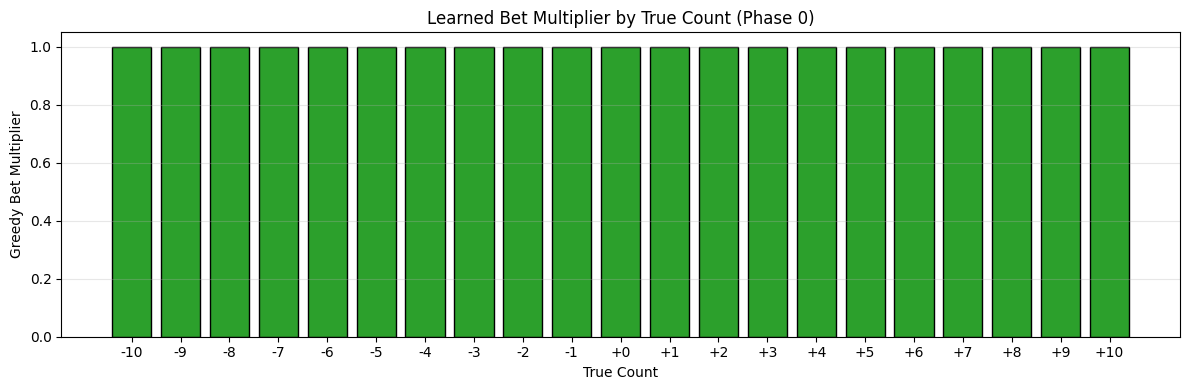

In [7]:
# Extract learned bet multiplier per true count (phase 0) and visualize
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

# Helper: argmax with deterministic tie-break (first max)
def _argmax(q: np.ndarray) -> int:
    return int(np.argmax(q))

base_env = getattr(env, 'unwrapped', env)
# Determine labels that match the number of TC buckets
n_buckets = int(base_env.observation_space.spaces[3].n)
n_bets = int(getattr(base_env, 'n_bets', 2))
maybe_names = getattr(base_env, 'tc_bucket_names', None)
if maybe_names is not None and len(maybe_names) == n_buckets:
    labels = np.array(list(maybe_names))  # pretty string labels (e.g., "≤-3".."≥+3")
else:
    labels = np.arange(int(base_env.tc_min), int(base_env.tc_max) + 1)

rows = []
for idx in range(n_buckets):
    # Phase-0 observation: before any cards are dealt
    s0 = (0, 0, 0, idx, 0)
    # Use the dedicated betting Q-table for this TC bucket
    q_bets = np.asarray(agent.Q_bet[idx], dtype=float)
    best = _argmax(q_bets)
    mult = float(base_env.bet_multipliers[best])
    visits_play = (hist_start_play[idx] if 'hist_start_play' in globals() else np.nan)
    visits_bet = (hist_start_bet[idx] if 'hist_start_bet' in globals() else np.nan)
    visits_total = (hist_start[idx] if 'hist_start' in globals() else np.nan)
    rows.append({
        'TC_idx': int(idx),
        'TC': labels[idx],
        'best_bet_action': int(best),
        'bet_multiplier': mult,
        'visits_play_training': int(visits_play) if not np.isnan(visits_play) else None,
        'visits_bet_training': int(visits_bet) if not np.isnan(visits_bet) else None,
        'visits_total': int(visits_total) if not np.isnan(visits_total) else None,
        'Q_bets': q_bets.copy(),
    })

bet_df = pd.DataFrame(rows).sort_values('TC_idx').reset_index(drop=True)
display(bet_df)

# Bar chart of chosen multiplier vs TC (optionally filter low-visit buckets)
min_visits = 0  # set to e.g. 1000 to hide low-data bins
plot_df = bet_df
if 'hist_start' in globals() and min_visits > 0:
    plot_df = bet_df[bet_df['visits_total'].fillna(0) >= min_visits]

plt.figure(figsize=(12, 4))
plt.bar(plot_df['TC'], plot_df['bet_multiplier'], color='tab:green', edgecolor='k')
plt.xlabel('True Count')
plt.ylabel('Greedy Bet Multiplier')
plt.title('Learned Bet Multiplier by True Count (Phase 0)')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

In [8]:
# === Visualization helpers for Q tables ===
import numpy as np
import matplotlib.pyplot as plt

def _dealer_tick_labels():
    # Dealer upcards ordered with Ace after 10
    return [str(i) for i in range(2, 11)] + ['A']  # 2..10, A

def plot_q_bet_heatmap(agent, env, annotate=False):
    """Heatmap of Q_bet with TC buckets on rows and bet actions on columns."""
    base = getattr(env, 'unwrapped', env)
    n_tc = int(base.observation_space.spaces[3].n)
    labels_tc = np.array(getattr(base, 'tc_bucket_names', [str(i) for i in range(n_tc)]))
    bet_multipliers = np.array(getattr(base, 'bet_multipliers', [1.0] * agent.Q_bet.shape[1]))
    bet_labels = [f"{m:g}x" for m in bet_multipliers]
    Q = np.array(agent.Q_bet, dtype=float)
    fig, ax = plt.subplots(figsize=(max(6, 1.2 * len(bet_labels)), max(4, 0.5 * len(labels_tc) + 1)))
    im = ax.imshow(Q, aspect='auto', cmap='viridis')
    cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label('Q value')
    ax.set_xticks(np.arange(len(bet_labels)), labels=bet_labels)
    ax.set_yticks(np.arange(len(labels_tc)), labels=labels_tc)
    ax.set_xlabel('Bet action (multiplier)')
    ax.set_ylabel('True Count bucket')
    ax.set_title('Q_bet heatmap')
    if annotate:
        for i in range(Q.shape[0]):
            for j in range(Q.shape[1]):
                ax.text(j, i, f"{Q[i, j]:.2f}", ha='center', va='center', color='w', fontsize=8)
    plt.tight_layout()
    plt.show()


def plot_q_play(agent, env, tc_idx=None, show='delta', vmin=None, vmax=None, reorder_dealer=True):
    """
    Visualize Q_play at a given TC bucket.
    show: 'delta' (Q_hit - Q_stand), 'stand', 'hit', 'surrender', 'double', or 'policy' (argmax).
    Two heatmaps are shown: UA=0 and UA=1.
    If reorder_dealer=True, moves Ace column (originally first) to the last position
    so dealer axis visually matches tick labels [2..10, A]. This assumes the raw
    dealer dimension indexes 1..10 for upcards (Ace=1, 2..10) with index 0 unused.
    """
    base = getattr(env, 'unwrapped', env)
    n_tc = int(base.observation_space.spaces[3].n)
    if tc_idx is None:
        tc_idx = n_tc // 2
    tc_idx = int(np.clip(tc_idx, 0, n_tc - 1))
    Q = agent.Q_play[:, :, :, tc_idx, :]  # (psum, dealer, usable, action)
    titles = {
        'delta': 'Q_hit - Q_stand',
        'stand': 'Q_stand',
        'hit': 'Q_hit',
        'surrender': 'Q_surrender',
        'double': 'Q_double',
        'policy': 'Greedy policy (0=stand,1=hit,2=surrender,3=double)'
    }

    # Dealer indices slice: skip index 0 (assumed dummy) -> 1..10 gives 10 columns (Ace,2..10) original order
    dealer_slice = slice(1, 11)  # produces 10 columns

    def _reorder(M):
        # M shape (..., 10) with columns [Ace,2,3,...,10]; move first to end -> [2,3,...,10,A]
        if not reorder_dealer:
            return M
        return np.concatenate([M[..., 1:], M[..., :1]], axis=-1)

    fig, axs = plt.subplots(1, 2, figsize=(12, 4), sharex=True, sharey=True)
    for u, ax in enumerate(axs):
        if show == 'policy':
            A = np.argmax(Q[:, :, u, :], axis=-1)  # (psum, dealer)
            Mraw = A[4:22, dealer_slice]          # player sums 4..21, dealer Ace,2..10
            M = _reorder(Mraw)
            im = ax.imshow(M, aspect='auto', cmap='tab10', vmin=0, vmax=3)
            cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04, ticks=[0, 1, 2, 3])
            cbar.ax.set_yticklabels(['Stand', 'Hit', 'Surrender', 'Double'])
        else:
            if show == 'delta':
                Mfull = Q[:, :, u, 1] - Q[:, :, u, 0]
                cbar_label = 'Q_hit - Q_stand'
                cmap = 'coolwarm'
            elif show == 'stand':
                Mfull = Q[:, :, u, 0]
                cbar_label = 'Q value (Stand)'; cmap = 'viridis'
            elif show == 'hit':
                Mfull = Q[:, :, u, 1]
                cbar_label = 'Q value (Hit)'; cmap = 'viridis'
            elif show == 'surrender':
                Mfull = Q[:, :, u, 2]
                cbar_label = 'Q value (Surrender)'; cmap = 'viridis'
            elif show == 'double':
                Mfull = Q[:, :, u, 3]
                cbar_label = 'Q value (Double)'; cmap = 'viridis'
            else:
                raise ValueError("show must be one of 'delta','stand','hit','surrender','double','policy'")
            Mraw = Mfull[4:22, dealer_slice]
            M = _reorder(Mraw)
            im = ax.imshow(M, aspect='auto', cmap=cmap, vmin=vmin, vmax=vmax)
            fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04, label=cbar_label)
        ax.set_title(f'UA={u}')
        ax.set_xlabel('Dealer upcard')
        ax.set_xticks(np.arange(10), labels=_dealer_tick_labels())
        ax.set_ylabel('Player sum' if u == 0 else '')
        ax.set_yticks(np.arange(18), labels=[str(ps) for ps in range(4, 22)])
    tc_label = getattr(base, 'tc_bucket_names', [str(i) for i in range(n_tc)])[tc_idx]
    fig.suptitle(f"Q_play ({titles.get(show, show)}) at TC bucket {tc_idx} ({tc_label})")
    plt.tight_layout()
    plt.show()

Output()

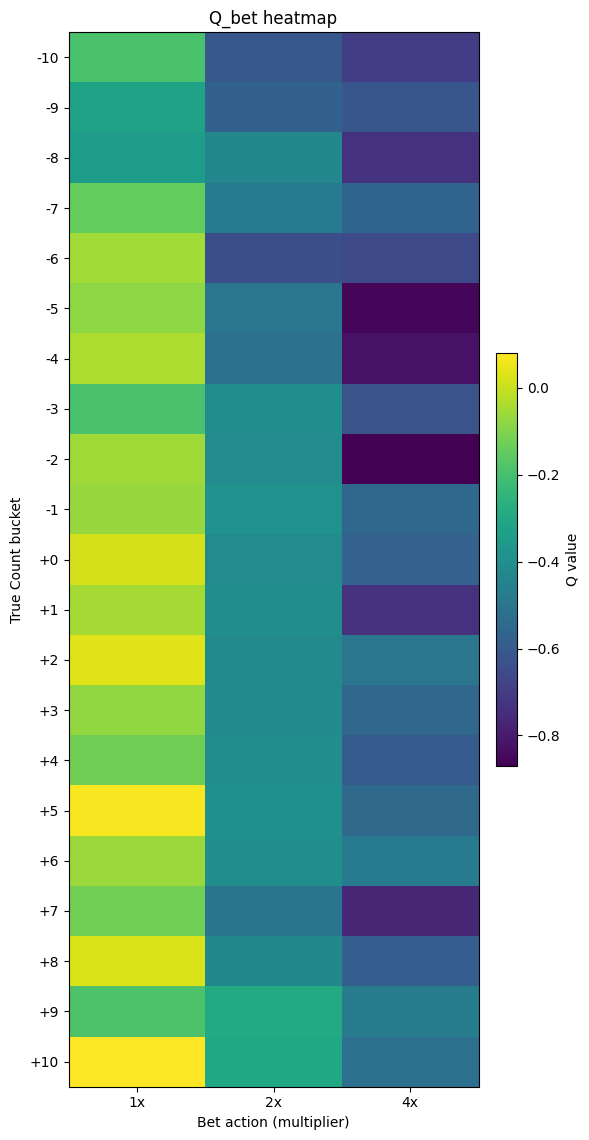

In [9]:
# === Q table visualization UI / examples ===
from IPython.display import display
try:
    import ipywidgets as widgets
    base = getattr(env, 'unwrapped', env)
    n_tc = int(base.observation_space.spaces[3].n)
    # Interactive selector for TC bucket and view type
    tc_slider = widgets.IntSlider(value=min(n_tc // 2, n_tc - 1), min=0, max=n_tc - 1, step=1, description='TC idx')
    show_dd = widgets.Dropdown(options=['policy', 'delta', 'stand', 'hit', 'surrender', 'double'], value='policy', description='View')
    out = widgets.Output()

    def _update(*args):
        with out:
            out.clear_output(wait=True)
            plot_q_play(agent, env, tc_idx=tc_slider.value, show=show_dd.value)

    tc_slider.observe(_update, names='value')
    show_dd.observe(_update, names='value')
    display(widgets.HBox([tc_slider, show_dd]))
    _update()
    display(out)
except Exception as e:
    print('ipywidgets not available or UI init failed; showing a static example...')
    plot_q_play(agent, env, tc_idx=0, show='policy')

# Also visualize Q_bet as a heatmap (set annotate=True to print values)
plot_q_bet_heatmap(agent, env, annotate=False)